# Packages

In [100]:
from langchain.sql_database import SQLDatabase
from sqlalchemy import create_engine
# from pyvis import network as net
import sqlite3
from langchain_ollama import ChatOllama
import networkx as nx
import matplotlib.pyplot as plt
# from pyvis.network import Network
# net = Network(notebook=True, directed=True, cdn_resources= "in_line")
# net.repulsion()  # Avoid node overlap
import matplotlib.patches as mpatches
from collections import defaultdict
import json
import re
import pandas as pd


In [6]:
llm = ChatOllama(model = "mistral", temparature= 0)

# DB connection

In [9]:
# Connect to SQLite database
# db_path = r"sqlite:///C:\Users\Sridhar\Documents\Langgraph_basics\sakila-sqlite3\sakila_master.db"

# db_path = r"C:\Users\Sridhar\Documents\Langgraph_basics\sakila-sqlite3\sakila_master.db"

db_path = r"C:\Users\A7778.AXTRIA\OneDrive - Axtria\Documents\Projects\text2sql_langgraph\sakila-sqlite3\sakila_master.db"
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Table Schema and column description

In [10]:
# # ✅ Step 2: Get All Table Names
# # cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_SCHEMA='sakila'")
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# tables = [row[0] for row in cursor.fetchall()]
# schema_descriptions ={}
# for table in tables:
#     print(table)
#     # 💣 Get columns using SQLite's PRAGMA
#     cursor.execute(f"PRAGMA table_info({table});")
#     columns = cursor.fetchall()

#     # ✅ Build Column Descriptions
#     columns_text = "\n".join([f"- {col[1]} ({col[2]})" for col in columns])  # col[1] = column name, col[2] = data type

#     # ✅ Prompt for LLM
#     prompt = f"""
#     The table "{table}" has the following columns:
#     {columns_text}

#     Can you describe what this table does and what each column means?
#     """
#     response = llm.invoke(prompt)

#     # ✅ Store the response
#     schema_descriptions[table] = response


# schema_descriptions= {i: j.content for i, j in schema_descriptions.items()}
# import json
# with open("schema_descriptions.txt", "w") as file:
#     file.write(str(schema_descriptions))

actor
country
city
address
language
category
customer
film
film_actor
film_category
film_text
inventory
staff
store
payment
rental


In [29]:
import ast
with open(r"schema_descriptions.txt", "r") as file:
    data = file.read()

In [34]:
schema_descriptions= ast.literal_eval(data)

In [35]:
schema_descriptions

{'actor': ' This table named "actor" is designed to store information about individual actors in a database. Here\'s a brief description of each column:\n\n1. actor_id (numeric): This column uniquely identifies each actor within the table. It serves as a primary key, ensuring no two actors have the same ID.\n\n2. first_name (VARCHAR(45)): This column stores the first name of the actor. The data type VARCHAR(45) indicates that it can store up to 45 characters for this field.\n\n3. last_name (VARCHAR(45)): This column stores the last name of the actor. Like the first_name, it also has a maximum length of 45 characters.\n\n4. last_update (TIMESTAMP): This column records when the actor\'s information was last updated in the database. It helps keep track of when changes were made and can be useful for auditing purposes or other tasks such as data archiving.',
 'country': ' This table named "country" is designed to store information about various countries in a database. Here\'s a brief expl

In [20]:
# for i, j in schema_descriptions.items():
#     print(j.content)
#     break

 This table named "actor" is designed to store information about individual actors in a database. Here's a brief description of each column:

1. `actor_id` (numeric): This column is used to uniquely identify each actor within the table. It acts as a primary key, ensuring that no two actors have the same ID.

2. `first_name` (VARCHAR(45)): This column stores the first name of the actor. The maximum length allowed for storing the first name is 45 characters.

3. `last_name` (VARCHAR(45)): This column stores the last name of the actor. Similar to the `first_name`, the maximum length allowed for storing the last name is also 45 characters.

4. `last_update` (TIMESTAMP): This column records when the data associated with a specific actor was last updated in the table. It helps in tracking changes and updates made to the record over time.

In summary, the "actor" table stores information about individual actors, such as their names and the timestamp of the last update made to their respective

In [27]:
# # Fetch all table names
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# tables = [row[0] for row in cursor.fetchall()]
# for table in tables:
#     cursor.execute(f"PRAGMA foreign_key_list({table})")
#     for row in cursor.fetchall():
#         fk_table = row[2]  # Referenced table
#         fk_column = row[3]  # FK column in this table
#         pk_column = row[4]  # PK column in referenced tabl
#         print(fk_column,"-->", pk_column,"---------------",  fk_table)

In [28]:
# def build_value_dict(G):
#     """Precompute a dictionary mapping values to columns from the NetworkX graph."""
#     value_to_columns = defaultdict(set)  # Using set to avoid duplicate columns

#     for node in G.nodes:
#         if G.nodes[node].get("node_type") == "Value":
#             column_names = [
#                 neighbor for neighbor in G.neighbors(node)
#                 if G.nodes[neighbor].get("node_type") == "Column"
#             ]
#             if column_names:
#                 value_to_columns[node.lower()].update(column_names)  # Lowercase for case-insensitive matching

#     return {key: list(value) for key, value in value_to_columns.items()} 
# build_value_dict(G)

In [29]:
# from collections import defaultdict

# unique_values = defaultdict(set)

# for table, columns in schema.items():
#     for column, _ in columns:
#         key = f"{table}.{column}"  # Key in table.column format
#         try:
#             cursor.execute(f"SELECT DISTINCT {column} FROM {table} LIMIT 84")
#             unique_values[key] = {str(row[0]) for row in cursor.fetchall() if row[0] is not None}
#         except Exception as e:
#             print(f"Skipping {key} due to error: {e}")  # Debugging logs (optional)
#             unique_values[f"{table}.{column}"].update(values)  # Ensure uniqueness per table.column

In [36]:
# Connect to SQLite database
# conn = sqlite3.connect("your_database.db")  # Change to your database
cursor = conn.cursor()

# Step 1: Extract Schema Information
schema = defaultdict(list)
foreign_keys = []  # Store foreign key relationships

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]

for table in tables:
    # Extract column names and data types
    cursor.execute(f"PRAGMA table_info({table})")
    columns = [(row[1], row[2]) for row in cursor.fetchall()]  # (Column Name, DataType)
    schema[table] = columns


# Step 2: Extract Unique Values for a subset of columns
unique_values = defaultdict(set)  # Stores values per column
lookup_dict = defaultdict(set)    # Stores columns per value

for table, columns in schema.items():
    for column, _ in columns:
        try:
            # Fetch unique values for the column
            cursor.execute(f"SELECT DISTINCT {column} FROM {table} LIMIT 34")
            values = {str(row[0]) for row in cursor.fetchall() if row[0] is not None}  # Convert to set
            
            # Store values under table.column key
            column_key = f"{table}.{column}"
            unique_values[column_key].update(values)

            # Store column references under each value key for fast lookup
            for value in values:
                lookup_dict[value.lower()].add(column_key)  # Store in lowercase for case-insensitive matching

        except Exception as e:
            print(f"Skipping {table}.{column} due to error: {e}")  # Debugging

    # Check the output
    # print("Unique Values Dictionary:", dict(unique_values))
    # print("Lookup Dictionary:", dict(lookup_dict))

    # Extract foreign keys (FKs)
    cursor.execute(f"PRAGMA foreign_key_list({table})")
    for row in cursor.fetchall():
        fk_table = row[2]  # Referenced table
        fk_column = row[3]  # FK column in this table
        pk_column = row[4]  # PK column in referenced table
        foreign_keys.append((table, fk_table, fk_column, pk_column))  # Store FK relation



In [43]:
lookup_dict

defaultdict(set,
            {'22': {'actor.actor_id',
              'address.address_id',
              'address.city_id',
              'city.city_id',
              'city.country_id',
              'country.country_id',
              'customer.address_id',
              'customer.customer_id',
              'film.film_id',
              'film_actor.actor_id',
              'film_actor.film_id',
              'film_category.film_id',
              'inventory.film_id',
              'inventory.inventory_id',
              'payment.customer_id',
              'payment.payment_id',
              'rental.customer_id',
              'rental.inventory_id',
              'rental.rental_id'},
             '27': {'actor.actor_id',
              'address.address_id',
              'address.city_id',
              'city.city_id',
              'city.country_id',
              'country.country_id',
              'customer.address_id',
              'customer.customer_id',
              'film.fil

In [6]:
unique_values

defaultdict(set,
            {'actor.actor_id': {'1',
              '10',
              '11',
              '12',
              '13',
              '14',
              '15',
              '16',
              '17',
              '18',
              '19',
              '2',
              '20',
              '21',
              '22',
              '23',
              '24',
              '25',
              '26',
              '27',
              '28',
              '29',
              '3',
              '30',
              '31',
              '32',
              '33',
              '34',
              '4',
              '5',
              '6',
              '7',
              '8',
              '9'},
             'actor.first_name': {'ALEC',
              'AUDREY',
              'BETTE',
              'BOB',
              'CAMERON',
              'CHRISTIAN',
              'CUBA',
              'DAN',
              'ED',
              'ELVIS',
              'FRED',
              'GRACE',


In [37]:
# Step 3: Build Knowledge Graph with NetworkX
G = nx.Graph()  # Undirected graph

# Color mapping for different node types
node_colors_map = {"Table": "red", "Column": "blue", "Value": "purple"}

# Add Table Nodes (Red)
for table in tables:
    G.add_node(table, node_type="Table", color=node_colors_map["Table"])

# Add Column Nodes (Blue) and Link to Tables
for table, columns in schema.items():
    for column, data_type in columns:
        column_node = f"{table}.{column}"
        G.add_node(column_node, node_type="Column", color=node_colors_map["Column"], data_type=data_type)
        G.add_edge(table, column_node, relation="has_column")

# Add Unique Value Nodes (Purple) and Link to Columns
for column, values in unique_values.items():
    for value in values:
        # value_node = f"Value:{value}"  # Prefix values to avoid confusion
        G.add_node(value, node_type="Value", color=node_colors_map["Value"])
        G.add_edge(column, value, relation="has_value")

# Add Foreign Key Relationships (Green)
for table, fk_table, fk_column, pk_column in foreign_keys:
    fk_node = f"{table}.{fk_column}"
    pk_node = f"{fk_table}.{pk_column}"
    
    if fk_node in G and pk_node in G:  # Ensure nodes exist before linking
        G.add_edge(fk_node, pk_node, relation="foreign_key", color="green")


# Graph plot

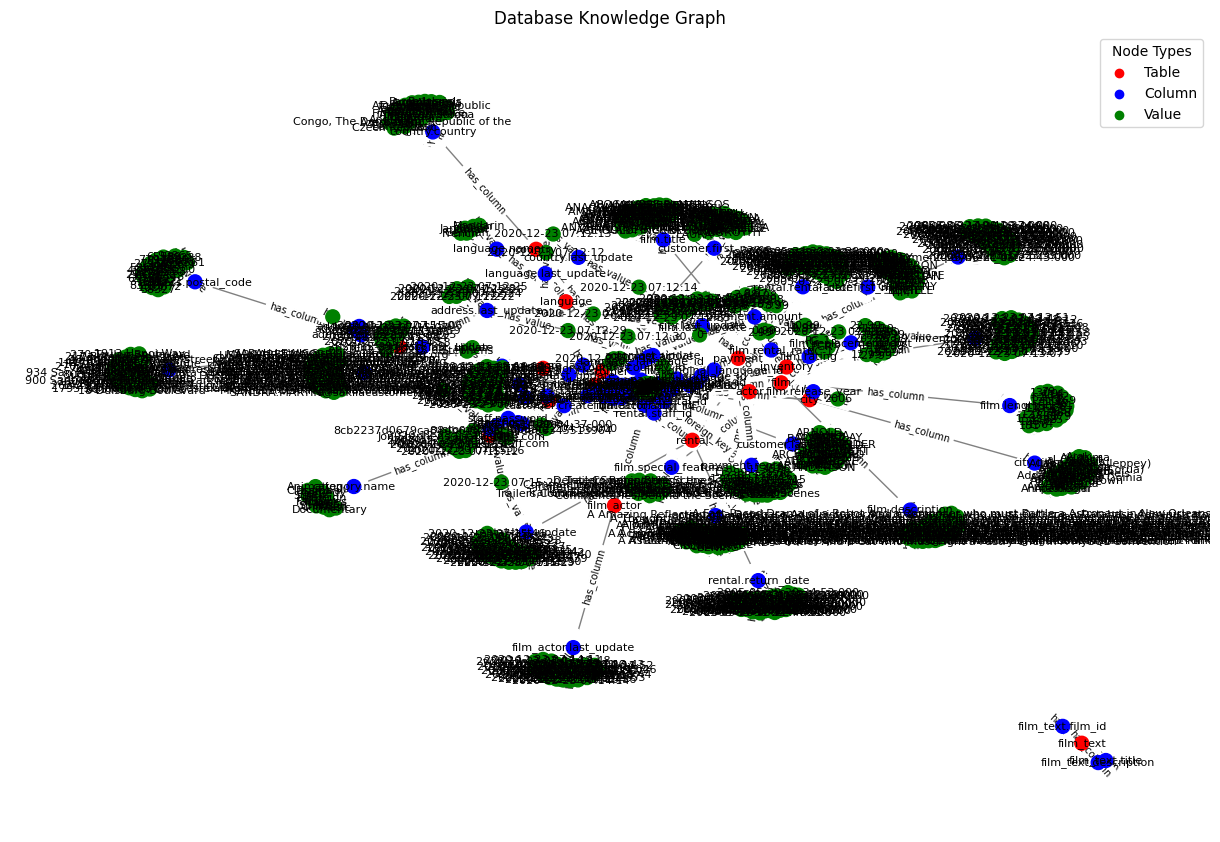

In [32]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_graph_with_legend(G):
    # Define color mapping
    node_colors_map = {"Table": "red", "Column": "blue", "Value": "green"}
    
    # Extract node colors
    node_colors = [node_colors_map.get(G.nodes[n].get("node_type", ""), "gray") for n in G.nodes]

    # Set graph layout
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="gray", node_size=100, font_size=8)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, "relation")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    # Create a legend
    legend_labels = {
        "Table": "red",
        "Column": "blue",
        "Value": "green"
    }
    for label, color in legend_labels.items():
        plt.scatter([], [], color=color, label=label)  # Empty scatter for legend

    plt.legend(title="Node Types")
    plt.title("Database Knowledge Graph")
    plt.show()

# Call the function
plot_graph_with_legend(G)


In [33]:
def get_table_details(table_name, G):
    if table_name not in G:
        print(f"Table '{table_name}' not found in the graph.")
        return

    print(f"📌 Details for Table: {table_name}\n")

    # Find columns linked to the table
    columns = [n for n in G.neighbors(table_name) if G.nodes[n]['node_type'] == "Column"]
    print("🔹 Columns:")
    for col in columns:
        data_type = G.nodes[col].get("data_type", "Unknown")
        print(f"   - {col} (Type: {data_type})")

        # Find unique values linked to each column
        values = [v for v in G.neighbors(col) if G.nodes[v]['node_type'] == "Value"]
        if values:
            print(f"     - Example Values: {values[:5]}")  # Show up to 5 values

# Example usage
get_table_details("film", G)  # Change "film" to any table in your dataset


📌 Details for Table: film

🔹 Columns:
   - film.film_id (Type: INT)
     - Example Values: ['14', '34', '30', '7', '33']
   - film.title (Type: VARCHAR(255))
     - Example Values: ['ANTITRUST TOMATOES', 'ACADEMY DINOSAUR', 'AFFAIR PREJUDICE', 'AMELIE HELLFIGHTERS', 'AFRICAN EGG']
   - film.description (Type: BLOB SUB_TYPE TEXT)
     - Example Values: ['A Epic Story of a Pastry Chef And a Woman who must Chase a Feminist in An Abandoned Fun House', 'A Insightful Drama of a Girl And a Astronaut who must Face a Database Administrator in A Shark Tank', 'A Epic Drama of a Feminist And a Mad Scientist who must Battle a Teacher in The Canadian Rockies', 'A Boring Epistle of a Butler And a Cat who must Fight a Pastry Chef in A MySQL Convention', 'A Lacklusture Display of a Dentist And a Dentist who must Fight a Girl in Australia']
   - film.release_year (Type: VARCHAR(4))
     - Example Values: ['2006']
   - film.language_id (Type: SMALLINT)
     - Example Values: ['1']
   - film.original_lang

In [34]:
import pandas as pd

def find_matching_columns(tokens, lookup_dict):
    """Find matching database columns for each identified token."""
    matches = []
    
    for token in tokens:
        token_lower = token.lower()  # Ensure case-insensitive matching
        if token_lower in lookup_dict:
            for column in lookup_dict[token_lower]:
                matches.append({"Token": token, "Matched Column": column})
    
    # Convert results into a DataFrame
    return pd.DataFrame(matches, columns=["Token", "Matched Column"])


# entities in the G

In [140]:
import pandas as pd

def find_entities(sentence, G):
    words = sentence.split()  # Tokenize words
    matches = []

    for word in words:
        word_lower = word.lower()

        for node in G.nodes:
            node_lower = node.lower()

            if word_lower == node_lower:
                node_type = G.nodes[node].get("node_type", "Unknown")

                if node_type == "Value":
                    # Find all columns where this value exists
                    column_names = [
                        neighbor
                        for neighbor in G.neighbors(node)
                        if G.nodes[neighbor].get("node_type") == "Column"
                    ]

                    matches.append({"Entity": word, "Matched In": ", ".join(column_names), "Type": "Value in Columns"})

                else:
                    matches.append({"Entity": word, "Matched In": node, "Type": node_type})

    return pd.DataFrame(matches)

# Example Query
sentence = "How many films are rated as city"
df_matches = find_entities(sent, G)

# Display as DataFrame
if not df_matches.empty:
    print("\nMatched Entities:")
    print(df_matches)
else:
    print("No entities found in the graph.")



Matched Entities:
   Entity                                         Matched In              Type
0       5  actor.actor_id, country.country_id, city.city_...  Value in Columns
1  rental                                             rental             Table


In [141]:
df_matches

,Entity,Matched In,Type
0,5,"actor.actor_id, country.country_id, city.city_...",Value in Columns
1,rental,rental,Table


# DB extraction of tables
# Table and columns and values to Graph

NameError: name 'State' is not defined

In [36]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def extract_subgraph_from_df(G, df_matches):
    """Extracts a subgraph including matched tables and their connecting keys."""
    
    subgraph_nodes = set()
    connecting_nodes = set()

    # Extract tables from df_matches
    matched_tables = set(df_matches["Matched Column"].apply(lambda x: x.split('.')[0]))

    # Add matched tables to subgraph
    subgraph_nodes.update(matched_tables)

    # Find foreign and primary keys that link these tables
    for node in G.nodes():
        if node in matched_tables:
            for neighbor in G.neighbors(node):
                if "id" in neighbor:  # Likely a key column
                    connecting_nodes.add(neighbor)
                    subgraph_nodes.add(neighbor)

    # Get relevant edges
    subgraph_edges = [(u, v) for u, v in G.edges() if u in subgraph_nodes and v in subgraph_nodes]

    return G.subgraph(subgraph_nodes | connecting_nodes)


# Extract subgraph
G_sub = extract_subgraph_from_df(G, df_matches)

# Define node colors
node_colors = []
for node in G_sub.nodes():
    if node in df_matches["Matched Column"].apply(lambda x: x.split('.')[0]).values:
        node_colors.append("red")  # Matched tables
    elif "id" in node:
        node_colors.append("yellow")  # Connecting keys
    else:
        node_colors.append("lightblue")  # Other nodes

# Define edge colors
edge_colors = ["green" if G_sub[u][v].get("relation") == "foreign_key" else
               "orange" if G_sub[u][v].get("relation") == "primary_key" else
               "black" for u, v in G_sub.edges()]

# Plot the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sub)  # Layout for better readability

nx.draw_networkx_nodes(G_sub, pos, node_color=node_colors, node_size=700)
nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, width=2)
nx.draw_networkx_labels(G_sub, pos, font_size=10, font_color="black")

# Legend
legend_patches = [
    mpatches.Patch(color="red", label="Matched Tables (city, language, film)"),
    mpatches.Patch(color="pink", label="Connecting Keys (city_id, language_id, film_id)"),
    mpatches.Patch(color="green", label="Foreign Key Edges"),
    mpatches.Patch(color="orange", label="Primary Key Edges"),
    mpatches.Patch(color="black", label="Other Edges")
]

plt.legend(handles=legend_patches, loc="best")
plt.title("Sakila Schema Subgraph for Matched Entities")
plt.show()

KeyError: 'Matched Column'

In [ ]:
# for u, v, data in G.edges(data=True):
#     if data.get("relation") == "foreign_key":
#         print(f"FK Edge: {u} --({data['relation']})--> {v}")


In [ ]:
# def find_join_paths(G_sub, df_matches):
#     """Find shortest join paths between matched tables in the subgraph."""
#     matched_tables = set(df_matches["Matched Column"].apply(lambda x: x.split('.')[0]))
#     join_paths = {}

#     for table1 in matched_tables:
#         for table2 in matched_tables:
#             if table1 != table2:
#                 try:
#                     path = nx.shortest_path(G_sub, source=table1, target=table2)
#                     join_paths[(table1, table2)] = path
#                 except nx.NetworkXNoPath:
#                     continue  # No direct path found

#     return join_paths

# # Example Usage
# join_paths = find_join_paths(G_sub, df_matches)
# print("Join Paths:", join_paths)


In [ ]:
# def find_table_and_relationships(G, matched_columns):
#     """Find tables and relationships for matched columns in NetworkX graph."""
#     results = []

#     for col in matched_columns:
#         if col in G:
#             connected_tables = [neighbor for neighbor in G.neighbors(col) if G.nodes[neighbor]['node_type'] == "Table"]
#             relationships = [
#                 {"Column": col, "Table": table, "Relation": G[col][table].get("relation", "has_column")}
#                 for table in connected_tables
#             ]
#             results.extend(relationships)
    
#     return pd.DataFrame(results, columns=["Column", "Table", "Relation"])

# # Example usage
# matched_columns = df_matches["Matched Column"].tolist()  # Columns matched from lookup
# df_relationships = find_table_and_relationships(G, matched_columns)

# # Print relationships
# print(df_relationships)


In [ ]:
# import networkx as nx
# import numpy as np
# from node2vec import Node2Vec

# def generate_node_embeddings(G, dimensions=16, walk_length=10, num_walks=100, workers=4):
#     # Step 1: Generate random walks and learn embeddings
#     node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=workers)
#     model = node2vec.fit(window=5, min_count=1, batch_words=4)  # Train the model

#     # Step 2: Store embeddings as node attributes
#     for node in G.nodes():
#         G.nodes[node]["embedding"] = model.wv[node]  # Save embedding in node attribute

#     print("Node embeddings generated and stored successfully!")

# # Call the function
# generate_node_embeddings(G)

# # Example: Access embedding for a node
# sample_node = list(G.nodes)[0]  # Pick any node
# print(f"Embedding for node '{sample_node}': {G.nodes[sample_node]['embedding']}")


In [ ]:
# **Calculate Overall Extraction Percentage**
extraction_percentage = round((extracted_columns / total_columns) * 100, 2) if total_columns else 0

# **Print Summary Metrics**
print(f"\n✅ **Overall Extraction Success: {extraction_percentage}%**")
print(f"📊 **Total Tables:** {len(tables)}")
print(f"📊 **Total Columns:** {total_columns}")
print(f"📊 **Columns Extracted with Unique Values:** {extracted_columns}")

print("\n🔍 **Per-Table Extraction Details:**")
for table, stats in table_stats.items():
    print(f" - {table}: {stats['extraction_percent']}% extracted ({stats['extracted_columns']}/{stats['total_columns']} columns)")

print("\n❌ **Missing or Failed Columns:**")
for table, column, reason in missing_data:
    print(f" - {table}.{column} → {reason}")


# ----------------------------------------------- Entity extraction  ----------------------------------------------


## 1. Extract the quoted text

In [38]:
import re

In [39]:
sent = """ abu dhabi is scientist' for a top company"""
sent =   "Get me the top 5 rented movies along with their rental count."

In [40]:
# Step 1: Extract Quoted Entities from User Input
def extract_quoted_entities(sentence):
    """Extracts words/phrases enclosed in single or double quotes."""
    matches = re.findall(r"'(.*?)'|\"(.*?)\"", sentence)
    return [entity for tup in matches for entity in tup if entity]  # Flatten tuple results


quoted_entities= extract_quoted_entities(sent)
quoted_entities

[]

## 2. Ngrams from sentence

In [41]:
# Step 2: Generate N-Grams (excluding quoted entities)
def clean_commas(sentence):
    # Simply replace commas with space
    return sentence.replace(",", " ")

# sent2 = "Im looking flor india,Amenrica, Srikanka"
# clean_commas(sent2)


def clean_trailing_punctuation(text):
    """Remove any trailing punctuation like . , ! ? from text."""
    return re.sub(r"[.,!?;:]+$", "", text)



def generate_ngrams(sentence, excluded_entities, max_n=5):
    """Generate n-grams up to max_n excluding quoted entities."""
    sentence= clean_commas(sentence)
    # Step 2.1: Remove quoted entities from the sentence entirely
    for entity in excluded_entities:
        sentence = sentence.replace(f"'{entity}'", "")
        sentence = sentence.replace(f'"{entity}"', "")
    
    # Step 2.2: Split remaining sentence into words
    words = sentence.split()

    # Step 2.3: Generate N-Grams from remaining words
    ngrams = []
    for n in range(max_n, 0, -1):
        for i in range(len(words) - n + 1):
            ngram = " ".join(words[i:i+n])
            clean_ngram = clean_trailing_punctuation(ngram)
            ngrams.append(clean_ngram)

    return ngrams

In [42]:
ngrams= generate_ngrams(sent, ["sridhar"])
ngrams

['Get me the top 5',
 'me the top 5 rented',
 'the top 5 rented movies',
 'top 5 rented movies along',
 '5 rented movies along with',
 'rented movies along with their',
 'movies along with their rental',
 'along with their rental count',
 'Get me the top',
 'me the top 5',
 'the top 5 rented',
 'top 5 rented movies',
 '5 rented movies along',
 'rented movies along with',
 'movies along with their',
 'along with their rental',
 'with their rental count',
 'Get me the',
 'me the top',
 'the top 5',
 'top 5 rented',
 '5 rented movies',
 'rented movies along',
 'movies along with',
 'along with their',
 'with their rental',
 'their rental count',
 'Get me',
 'me the',
 'the top',
 'top 5',
 '5 rented',
 'rented movies',
 'movies along',
 'along with',
 'with their',
 'their rental',
 'rental count',
 'Get',
 'me',
 'the',
 'top',
 '5',
 'rented',
 'movies',
 'along',
 'with',
 'their',
 'rental',
 'count']

In [43]:
# === Step 3: Generate Variants Dynamically ===
def generate_variants(ngrams, separators=["_", "-", "*"]):
    """Generate variants from n-grams using separators like '_' or '-'."""
    variant_dict = defaultdict(set)
    
    for ngram in ngrams:
        words = ngram.split()
        if len(words) > 1:  # Only create variants for multi-word phrases
            for sep in separators:
                joined = sep.join(words)
                collapsed = "".join(words)
                variant_dict[ngram.lower()].update([joined.lower(), collapsed.lower()])
        else:
            variant_dict[ngram.lower()].add(ngram.lower())
    
    return variant_dict

In [44]:
question_dict = generate_variants(ngrams) #, separators=["_", "-"])

# question dict

In [45]:
question_dict

defaultdict(set,
            {'get me the top 5': {'get*me*the*top*5',
              'get-me-the-top-5',
              'get_me_the_top_5',
              'getmethetop5'},
             'me the top 5 rented': {'me*the*top*5*rented',
              'me-the-top-5-rented',
              'me_the_top_5_rented',
              'methetop5rented'},
             'the top 5 rented movies': {'the*top*5*rented*movies',
              'the-top-5-rented-movies',
              'the_top_5_rented_movies',
              'thetop5rentedmovies'},
             'top 5 rented movies along': {'top*5*rented*movies*along',
              'top-5-rented-movies-along',
              'top5rentedmoviesalong',
              'top_5_rented_movies_along'},
             '5 rented movies along with': {'5*rented*movies*along*with',
              '5-rented-movies-along-with',
              '5_rented_movies_along_with',
              '5rentedmoviesalongwith'},
             'rented movies along with their': {'rented*movies*along*with

In [46]:
def extract_entity_meta(matched_entities):
    return [
        {
            "entity_value": value,
            "table": column.split(".")[0],
            "column": column.split(".")[1]
        }
        for value, columns in matched_entities
        for column in columns
    ]


# === Step 3: Match Keys First, Then Variants ===
def find_entities(question_dict, lookup_dict):
    matches = []

    # ✅ Step 1: Check if the key exists in lookup_dict (exact match)
    for n_gram, variants in question_dict.items():
        n_gram_lower = n_gram.lower()

        # 🔥 Exact Match Check First
        if n_gram_lower in lookup_dict:
            # ✅ Exact match found → store it immediately
            matches.append((n_gram, list(lookup_dict[n_gram_lower])))
            continue  # 🚀 No need to check variants

        # 🔥 Step 2: No exact match → Try Variants
        for variant in variants:
            variant_lower = variant.lower()
            if variant_lower in lookup_dict:
                # ✅ Variant match found → store it
                matches.append((variant, list(lookup_dict[variant_lower])))
                break  # 🚀 Stop after the first successful variant match
    entities_meta = extract_entity_meta(matches)
    return entities_meta

In [47]:
  "Get me the top 5 rented movies along with their rental count.",

('Get me the top 5 rented movies along with their rental count.',)

In [48]:
# === Step 4: Run the Matcher ===
matched_entities = find_entities(question_dict, lookup_dict)
matched_entities

[{'entity_value': '5', 'table': 'category', 'column': 'category_id'},
 {'entity_value': '5', 'table': 'city', 'column': 'country_id'},
 {'entity_value': '5', 'table': 'address', 'column': 'city_id'},
 {'entity_value': '5', 'table': 'country', 'column': 'country_id'},
 {'entity_value': '5', 'table': 'actor', 'column': 'actor_id'},
 {'entity_value': '5', 'table': 'customer', 'column': 'customer_id'},
 {'entity_value': '5', 'table': 'address', 'column': 'address_id'},
 {'entity_value': '5', 'table': 'rental', 'column': 'rental_id'},
 {'entity_value': '5', 'table': 'inventory', 'column': 'inventory_id'},
 {'entity_value': '5', 'table': 'film_category', 'column': 'category_id'},
 {'entity_value': '5', 'table': 'city', 'column': 'city_id'},
 {'entity_value': '5', 'table': 'film_actor', 'column': 'actor_id'},
 {'entity_value': '5', 'table': 'film', 'column': 'film_id'},
 {'entity_value': '5', 'table': 'film_category', 'column': 'film_id'},
 {'entity_value': '5', 'table': 'rental', 'column': '

# Final

In [49]:
def entity_extraction(user_question):
    quoted_entities= extract_quoted_entities(user_question)
    ngrams= generate_ngrams(user_question, quoted_entities)
    
    question_dict = generate_variants(ngrams, separators=["_", "-"])
    matched_entities = find_entities(question_dict, lookup_dict)
    return matched_entities

In [50]:
#entity_extraction(sent)

In [155]:
questions= ["Show me all the actors",
            "Give me the list of films",
"Find all the categories of movies",
"List down all the customers",
"Get me the list of cities",
"Tell me the payment methods available",
"Show me all the stores",
"Get me the countries listed"]


medium_questions = [
    "Show me movies released in 2006 and find the rental_duration for Canada",
    "List all customers from Canada.",
    "Find actors with the first name 'Johnny' .",
    "Give me films longer than 120 minutes.",
    "Get customers whose email ends with '@gmail.com'.",
    "Find all movies rated PG-13.",
    "List movies having rental rate more than $2.",
    "Find actors whose last name starts with 'S'."
]

advanced_questions = [
    "Show me all films along with their categories.",
    "Get me the top 5 rented movies along with their rental count.",
    "Show me customers who rented 'ACADEMY DINOSAUR'.",
    "List actors who acted in 'ANGELS LIFE'.",
    "Find customers who made payment more than $100.",
    "Show me the list of cities along with their countries.",
    "Get all films rented by customer 'Mary Smith'.",
    "Show me customers who have never made a payment.",
    "List movies that have never been rented.",
    "Find actors who acted in more than 20 movies."
]


# Test

In [180]:
for i in medium_questions+advanced_questions:
    print(entity_extraction(i))

[{'entity_value': '2006', 'table': 'film', 'column': 'release_year'}, {'entity_value': 'canada', 'table': 'country', 'column': 'country'}]
[{'entity_value': 'canada', 'table': 'country', 'column': 'country'}]
[]
[]
[]
[{'entity_value': 'pg-13', 'table': 'film', 'column': 'rating'}]
[]
[]
[]
[{'entity_value': '5', 'table': 'payment', 'column': 'customer_id'}, {'entity_value': '5', 'table': 'country', 'column': 'country_id'}, {'entity_value': '5', 'table': 'film', 'column': 'rental_duration'}, {'entity_value': '5', 'table': 'film_actor', 'column': 'film_id'}, {'entity_value': '5', 'table': 'customer', 'column': 'address_id'}, {'entity_value': '5', 'table': 'rental', 'column': 'rental_id'}, {'entity_value': '5', 'table': 'inventory', 'column': 'inventory_id'}, {'entity_value': '5', 'table': 'film_actor', 'column': 'actor_id'}, {'entity_value': '5', 'table': 'city', 'column': 'country_id'}, {'entity_value': '5', 'table': 'customer', 'column': 'customer_id'}, {'entity_value': '5', 'table': 

# Langgraph

In [51]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List
from IPython.display import Image, display

In [52]:
#  System prompt for SQL generation
SYSTEM_PROMPT = """
You are an expert SQL generator.
Given a user question and database schema, generate a perfect SQL query.
### Table schema
{schema}

### User Query
{user_question}

### SQL Query (Only SQL, no natural language response)
"""

In [56]:
from typing import Annotated
import operator

# State

In [102]:
class State(TypedDict):
    user_question: str
    entities: List[str]
    schema: Annotated[str, operator.add]
    potential_tables: List[str]
    sql: str
    result : str

In [103]:
sent= 'Show me movies released in 2006 and find the rental_duration for Canada'

In [104]:
#  Generate SQL from user query
def generate_sql(state: State) -> State:
   
    prompt = SYSTEM_PROMPT.format(schema=schema, user_question=state['user_question'])
    
    result = llm.invoke(prompt)
    print(result)
    state['sql'] = result.content.strip()
    return state

# Schema selection()

In [105]:

def get_table_schema(state:State):
    """ Give the table details alonng with column name and it description"""
    
    potential_table = state["schema"]
    schema = schema_descriptions[potential_table]
    state["schema"]= schema
    return state

In [106]:
#get_schema({"schema": "film"})



# SQL Execution

In [107]:
# Execute SQL and get results
def execute_sql(state: State) -> State:
    cursor.execute(state['sql'])
    state['result'] = cursor.fetchall()
    return state

In [108]:
sql = {"sql": """select * from film limit 10 """}

In [109]:
pd.DataFrame(execute_sql(sql)["result"]).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2020-12-23 07:12:31
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2020-12-23 07:12:31


In [110]:
def entity_extraction(state:State):
    """
    Node 1: Extract entities from the user question.
    """
    quoted_entities= extract_quoted_entities(state["user_question"])
    ngrams= generate_ngrams(state["user_question"], quoted_entities)
    
    question_dict = generate_variants(ngrams, separators=["_", "-"])
    matched_entities = find_entities(question_dict, lookup_dict)
    state['entities'] = matched_entities

    # Potentil tables to look at based on the entities extracted
    df = pd.DataFrame(matched_entities)
    potential_tables = list(df["table"].unique())
    state['potential_tables'] = matched_entities
    return state

In [111]:
sent=  "Show me movies released in 2006 and find the rental_duration for Canada"

In [112]:
entities = entity_extraction({ "user_question":sent}) # "Show me movies from India, Brazil and Sri Lanka."})

In [113]:
import pandas as pd

In [114]:
entities

{'user_question': 'Show me movies released in 2006 and find the rental_duration for Canada',
 'entities': [{'entity_value': '2006',
   'table': 'film',
   'column': 'release_year'},
  {'entity_value': 'canada', 'table': 'country', 'column': 'country'}],
 'potential_tables': [{'entity_value': '2006',
   'table': 'film',
   'column': 'release_year'},
  {'entity_value': 'canada', 'table': 'country', 'column': 'country'}]}

In [115]:
# from typing import Any

# from langchain_core.messages import ToolMessage
# from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
# from langgraph.prebuilt import ToolNode


# def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
#     """
#     Create a ToolNode with a fallback to handle errors and surface them to the agent.
#     """
#     return ToolNode(tools).with_fallbacks(
#         [RunnableLambda(handle_tool_error)], exception_key="error"
#     )


# def handle_tool_error(state) -> dict:
#     error = state.get("error")
#     tool_calls = state["messages"][-1].tool_calls
#     return {
#         "messages": [
#             ToolMessage(
#                 content=f"Error: {repr(error)}\n please fix your mistakes.",
#                 tool_call_id=tc["id"],
#             )
#             for tc in tool_calls
#         ]
#     }

In [117]:
text2sql_builder = StateGraph(State)
text2sql_builder.add_node("entities_extraction", entity_extraction)
text2sql_builder.add_node("get_table_schema", get_table_schema)
text2sql_builder.add_node("generate_sql", generate_sql)
text2sql_builder.add_node("execute_sql", execute_sql)



text2sql_builder.add_edge(START, "entities_extraction")
text2sql_builder.add_edge("entities_extraction", "get_table_schema")
text2sql_builder.add_edge("entities_extraction", "generate_sql")
text2sql_builder.add_edge("generate_sql", "execute_sql")
text2sql_builder.add_edge("execute_sql", END)

graph = text2sql_builder.compile()

In [119]:
#Image(graph.get_graph().draw_mermaid_png())

In [120]:
sent= "give me list film table with release_year 2006"

In [121]:
response = graph.invoke({
    "user_question":sent # "Show me movies from India, Brazil and Sri Lanka."
})

content=" SELECT * FROM film WHERE release_year = 2006;\n\nAssuming the table name is 'film' and the column for year of release is named 'release_year'. If not, adjust accordingly." additional_kwargs={} response_metadata={'model': 'mistral', 'created_at': '2025-03-10T11:25:42.6544631Z', 'done': True, 'done_reason': 'stop', 'total_duration': 22841765700, 'load_duration': 5636345600, 'prompt_eval_count': 67, 'prompt_eval_duration': 7711000000, 'eval_count': 48, 'eval_duration': 9490000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)} id='run-8a15058e-8d17-4449-8b60-98c4613655bc-0' usage_metadata={'input_tokens': 67, 'output_tokens': 48, 'total_tokens': 115}


KeyError: ''

In [157]:
response["sql"]

'SELECT * FROM film WHERE release_year = 2006;'

In [156]:
pd.DataFrame(response["result"])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2020-12-23 07:12:31
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2020-12-23 07:12:31
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2020-12-23 07:12:31
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2020-12-23 07:12:31
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,Deleted Scenes,2020-12-23 07:12:31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,YOUNG LANGUAGE,A Unbelieveable Yarn of a Boat And a Database ...,2006,1,None,6,0.99,183,9.99,G,"Trailers,Behind the Scenes",2020-12-23 07:12:45
996,997,YOUTH KICK,A Touching Drama of a Teacher And a Cat who mu...,2006,1,None,4,0.99,179,14.99,NC-17,"Trailers,Behind the Scenes",2020-12-23 07:12:45
997,998,ZHIVAGO CORE,A Fateful Yarn of a Composer And a Man who mus...,2006,1,None,6,0.99,105,10.99,NC-17,Deleted Scenes,2020-12-23 07:12:45
998,999,ZOOLANDER FICTION,A Fateful Reflection of a Waitress And a Boat ...,2006,1,None,5,2.99,101,28.99,R,"Trailers,Deleted Scenes",2020-12-23 07:12:45


In [153]:
response["entities"]

[{'entity_value': '2006', 'table': 'film', 'column': 'release_year'}]

# find the joins using KG

In [201]:
def detect_required_joins(entities, G):
    """
    Identify if joins are required based on extracted entities and graph traversal.
    Minimize joins and avoid unnecessary hops.
    """
    matched_tables = set(e["table"] for e in entities)
    join_paths = {}
    required_joins = []

    # 🚀 Check pairwise tables for shortest path
    for table1 in matched_tables:
        for table2 in matched_tables:
            if table1 != table2:
                try:
                    # 💎 Find shortest path in the graph
                    path = nx.shortest_path(G, source=table1, target=table2)
                    if len(path) > 1:
                        join_paths[(table1, table2)] = path
                except nx.NetworkXNoPath:
                    # 💀 No join path exists
                    continue

    # ✅ Now intelligently minimize joins
    for (t1, t2), path in join_paths.items():
        for i in range(len(path) - 1):
            from_table = path[i]
            to_table = path[i+1]

            # 💡 Find the actual join columns
            for edge in G.edges(data=True):
                if edge[0] == from_table and edge[1] == to_table:
                    join_info = edge[2]
                    if join_info.get("relation") == "foreign_key":
                        required_joins.append({
                            "from_table": from_table,
                            "from_column": join_info["from_column"],
                            "to_table": to_table,
                            "to_column": join_info["to_column"]
                        })

    return required_joins

# 🚀 Example Usage
required_joins = detect_required_joins(response["entities"], G)
print(required_joins)


[]


In [202]:
response["entities"]

[{'entity_value': '2006', 'table': 'film', 'column': 'release_year'},
 {'entity_value': 'canada', 'table': 'country', 'column': 'country'}]

In [194]:
df_matches = pd.DataFrame(response["entities"])

In [198]:
import networkx as nx

def find_join_paths(G, df_matches):
    """
    Find shortest join paths between matched tables in the graph.
    This time, NO SUBGRAPH. We use the full G.
    """
    matched_tables = set(df_matches["table"])
    join_paths = {}

    # ✅ Iterate over all pairs of matched tables
    for table1 in matched_tables:
        for table2 in matched_tables:
            if table1 != table2:
                try:
                    # 🚀 Find the shortest path between two tables
                    path = nx.shortest_path(G, source=table1, target=table2)

                    # 💥 Extract the JOIN columns from the graph edges
                    join_columns = []
                    for i in range(len(path)-1):
                        src = path[i]
                        dest = path[i+1]

                        # 💣 Get the edge data to understand how they are linked
                        if G.has_edge(src, dest):
                            edge_data = G.get_edge_data(src, dest)
                            relation = edge_data.get('relation', None)

                            if relation == "foreign_key":
                                # Extract the FK → PK Join
                                join_columns.append({
                                    "from_table": src.split('.')[0],
                                    "from_column": src.split('.')[1],
                                    "to_table": dest.split('.')[0],
                                    "to_column": dest.split('.')[1]
                                })

                    # 🚀 Store the join path and columns
                    join_paths[(table1, table2)] = {
                        "path": path,
                        "join_columns": join_columns
                    }

                except nx.NetworkXNoPath:
                    continue  # No path found, skip

    return join_paths

# 🚀 Find join paths using full graph G
join_paths = find_join_paths(G, df_matches)

# # 💣 Print the join paths
# for k, v in join_paths.items():
#     print(f"Path from {k[0]} → {k[1]}")
#     print("Path:", v["path"])
#     print("Joins:")
#     for join in v["join_columns"]:
#         print(f"  {join['from_table']}.{join['from_column']} → {join['to_table']}.{join['to_column']}")
#     print("-----")


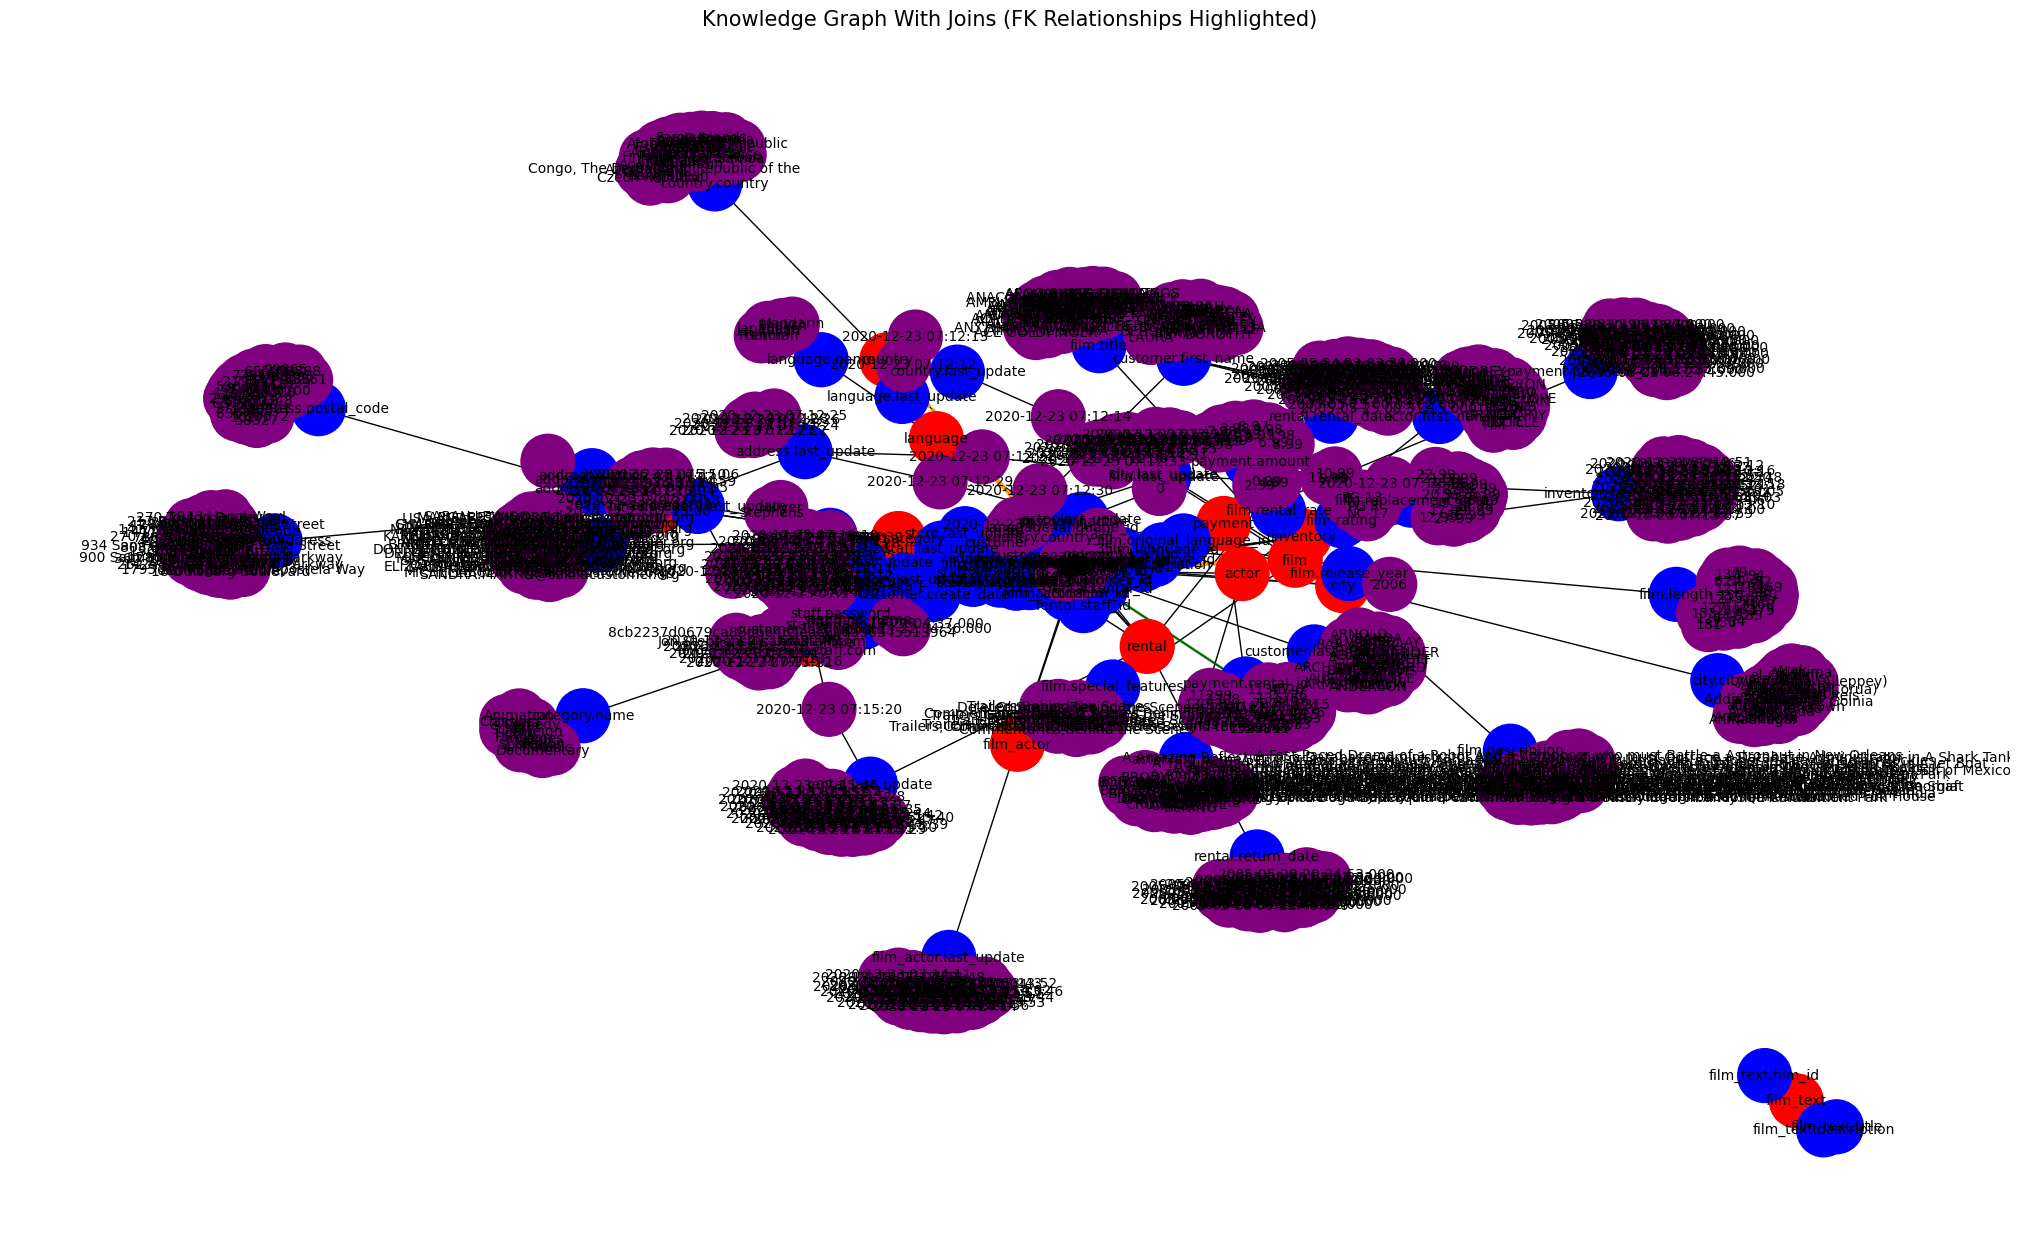

In [199]:
import matplotlib.pyplot as plt
import networkx as nx

# === Step 1: Plot the Full Graph with FK Highlighted ===
def plot_graph_with_fks(G, df_matches, join_paths):
    plt.figure(figsize=(20, 12))
    
    # ✅ Extract Node Colors
    color_map = []
    for node in G.nodes():
        node_type = G.nodes[node].get("node_type", "")
        if node_type == "Table":
            color_map.append("red")
        elif node_type == "Column":
            color_map.append("blue")
        elif node_type == "Value":
            color_map.append("purple")
        else:
            color_map.append("gray")
    
    # ✅ Draw The Full Graph
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1500, font_size=10)
    
    # ✅ Step 2: Highlight Foreign Key Relationships
    for u, v, data in G.edges(data=True):
        if data.get("relation") == "foreign_key":
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u, v)], edge_color="green", width=2, alpha=0.7
            )
    
    # ✅ Step 3: Highlight Shortest Join Paths (If Any)
    for k, v in join_paths.items():
        path = v["path"]
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(
            G, pos, edgelist=path_edges, edge_color="orange", width=3, alpha=0.9, style="dashed"
        )
    
    # ✅ Add Legend
    plt.title("Knowledge Graph With Joins (FK Relationships Highlighted)", fontsize=15)
    plt.show()


# === Step 2: Call The Function To Plot ===
plot_graph_with_fks(G, df_matches, join_paths)


In [195]:
df_matches

,entity_value,table,column
0,2006,film,release_year
1,canada,country,country


In [200]:
join_paths

{('country',
  'film'): {'path': ['country',
   'country.country_id',
   '14',
   'film.film_id',
   'film'], 'join_columns': []},
 ('film',
  'country'): {'path': ['film',
   'film.film_id',
   '14',
   'country.country_id',
   'country'], 'join_columns': []}}